In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120


## Load Data – AESO Hourly Load (2011–2024)

This dataset contains Alberta’s hourly electricity demand from 2011 to 2024. 
The timestamp column (`DT_MST`) represents Alberta local time, and demand is recorded for multiple areas and regions. 
The data is used as the foundation for trend analysis, regional comparison, and surge detection.


In [ ]:
# Final cleaned load file 
load_path = Path("AESO_Load_All_Years_NoDuplicates.csv")

df_load = pd.read_csv(load_path, parse_dates=["DT_MST"])
print("Load data shape:", df_load.shape)
print(df_load.head(3))

Load data shape: (122726, 49)
               DT_MST     AREA13     AREA17    AREA18     AREA19      AREA20  \
0 2011-01-01 00:00:00  88.074635  72.479303  18.82104  138.61838  257.857343   
1 2011-01-01 01:00:00  85.638316  71.626921  18.08736  137.12338  254.185227   
2 2011-01-01 02:00:00  84.130155  70.904240  17.47680  135.78402  251.299487   

     AREA21    AREA22     AREA23     AREA24  ...     AREA56     AREA57  \
0  84.96768  27.27024  26.277332  61.375534  ...  58.012041  59.015744   
1  83.56032  26.63632  25.391039  61.292160  ...  56.141569  56.509702   
2  82.72968  26.59756  25.011245  60.986664  ...  55.132345  54.802931   

        AREA6       AREA60      CALGARY      CENTRAL     EDMONTON  \
0  985.524051  1190.645294  1044.539795  1679.371701  1435.674681   
1  939.363308  1151.413283   995.873010  1651.468672  1387.974622   
2  902.659208  1114.089958   957.462139  1639.158579  1343.982859   

     NORTHEAST    NORTHWEST        SOUTH  
0  1951.272821  1004.540852  103

### Data Quality Check

A basic validation was performed to ensure data reliability:
- Checked for missing timestamps
- Checked for duplicate timestamps
- Reviewed summary statistics
The dataset contained no major structural issues.


In [28]:
missing = df_load["DT_MST"].isna().sum()
dupes = df_load["DT_MST"].duplicated().sum()
print("Missing timestamps:", missing)
print("Duplicate timestamps:", dupes)

Missing timestamps: 0
Duplicate timestamps: 0


In [29]:
df_load.describe().T[["mean","min","max"]].round(2).head()

,mean,min,max
DT_MST,2018-01-01 01:09:04.901650688,2011-01-01 00:00:00,2024-12-31 23:00:00
AREA13,91.8174,47.174345,145.002249
AREA17,42.42023,0.4723,83.871641
AREA18,30.446784,0.0,54.915703
AREA19,123.872061,42.86597,207.320427


## Feature Engineering

A new column `TOTAL_LOAD` was created by summing all AREA columns to represent total provincial demand.
Additional time-based features were extracted from the timestamp, including:
`YEAR`, `MONTH`, `HOUR`, `DAY_OF_WEEK`, and `SEASON`.
These features support trend, seasonal, and hourly analysis.

In [30]:
# All AREA columns contribute to TOTAL_LOAD
area_cols = [c for c in df_load.columns if c.startswith("AREA")]
df_load["TOTAL_LOAD"] = df_load[area_cols].sum(axis=1)

# Time-based features
df_load["YEAR"]        = df_load["DT_MST"].dt.year
df_load["MONTH"]       = df_load["DT_MST"].dt.month
df_load["HOUR"]        = df_load["DT_MST"].dt.hour
df_load["DAY_OF_WEEK"] = df_load["DT_MST"].dt.day_name()

season_map = {
    12:"Winter", 1:"Winter", 2:"Winter",
    3:"Spring", 4:"Spring", 5:"Spring",
    6:"Summer", 7:"Summer", 8:"Summer",
    9:"Fall", 10:"Fall", 11:"Fall"
}
df_load["SEASON"] = df_load["MONTH"].map(season_map)

## EDA – Load (2011–2024)

### Annual Trend Analysis

Annual average load was calculated to observe long-term changes in electricity demand.
The trend shows gradual growth over time, a noticeable dip around 2020, and partial recovery afterward.


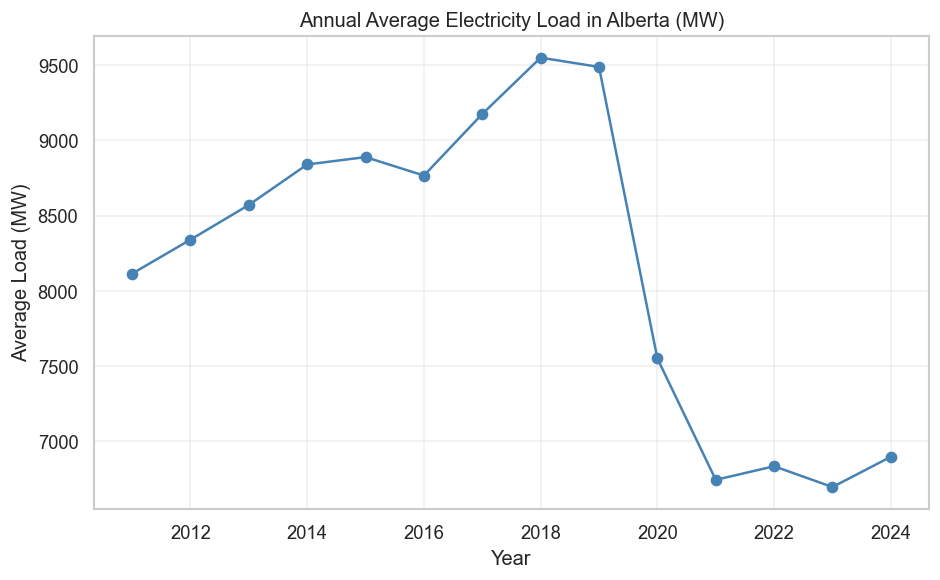

In [31]:
annual = df_load.groupby("YEAR")["TOTAL_LOAD"].mean()

plt.figure(figsize=(8,5))
plt.plot(annual.index, annual.values, marker="o", color="steelblue")
plt.title("Annual Average Electricity Load in Alberta (MW)")
plt.xlabel("Year")
plt.ylabel("Average Load (MW)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Monthly Pattern Analysis

Monthly averages, medians, and variability were calculated.
Winter months show the highest demand, while spring and early summer show relatively lower usage.


Monthly mean/median/std (MW):
          mean     50%     std
MONTH                        
1      8845.2  9083.0  1286.0
2      8806.8  9021.9  1273.4
3      8476.2  8740.9  1238.2
4      7933.3  8182.1  1083.9
5      7462.2  7518.2  1105.3
6      7671.2  7682.7  1131.0
7      8063.7  8129.3  1191.7
8      8005.1  8107.4  1225.9
9      7720.1  7872.3  1182.8
10     7926.1  8120.4  1210.8
11     8471.2  8681.1  1263.8
12     8752.3  8991.4  1296.9


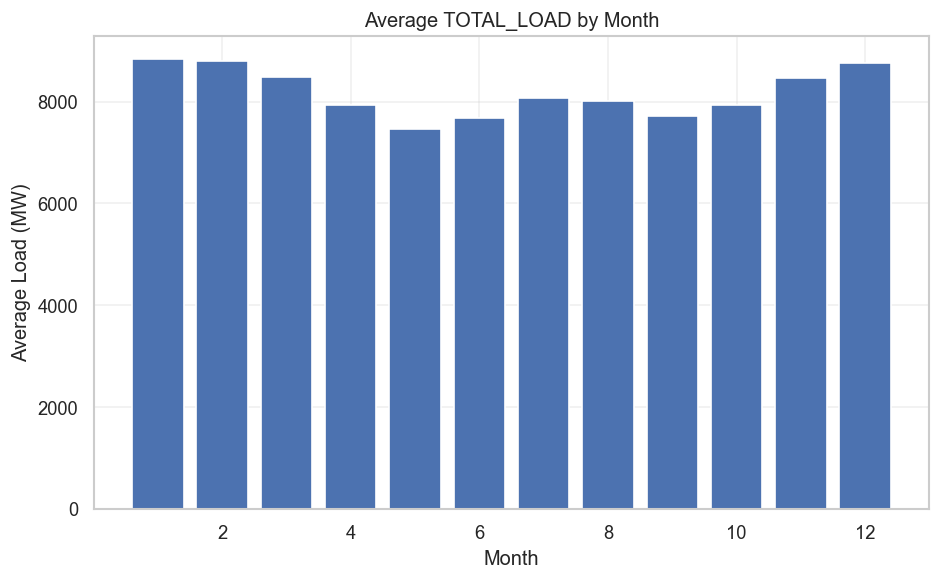

In [32]:
monthly_stats = df_load.groupby("MONTH")["TOTAL_LOAD"].describe()[["mean", "50%", "std"]]
print("\nMonthly mean/median/std (MW):\n", monthly_stats.round(1))

plt.figure(figsize=(8,5))
plt.bar(monthly_stats.index, monthly_stats["mean"])
plt.title("Average TOTAL_LOAD by Month")
plt.xlabel("Month")
plt.ylabel("Average Load (MW)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Hourly Pattern Analysis

Hourly averages show lowest demand during late night/early morning hours and peak demand during the evening (around 4–7 PM).
This reflects typical residential and commercial consumption behavior.

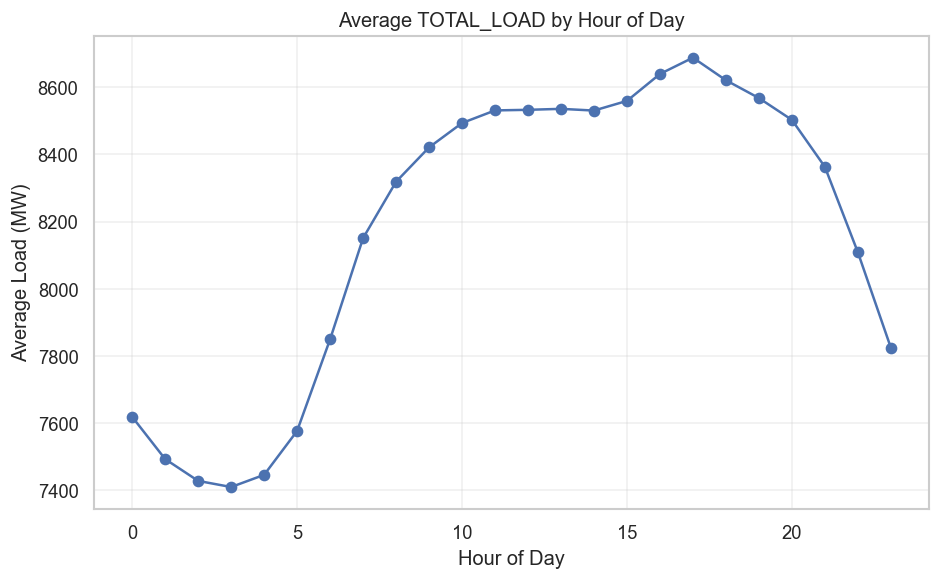

In [33]:
hourly = df_load.groupby("HOUR")["TOTAL_LOAD"].mean()

plt.figure(figsize=(8,5))
plt.plot(hourly.index, hourly.values, marker="o")
plt.title("Average TOTAL_LOAD by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Load (MW)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Monthly variation boxplot

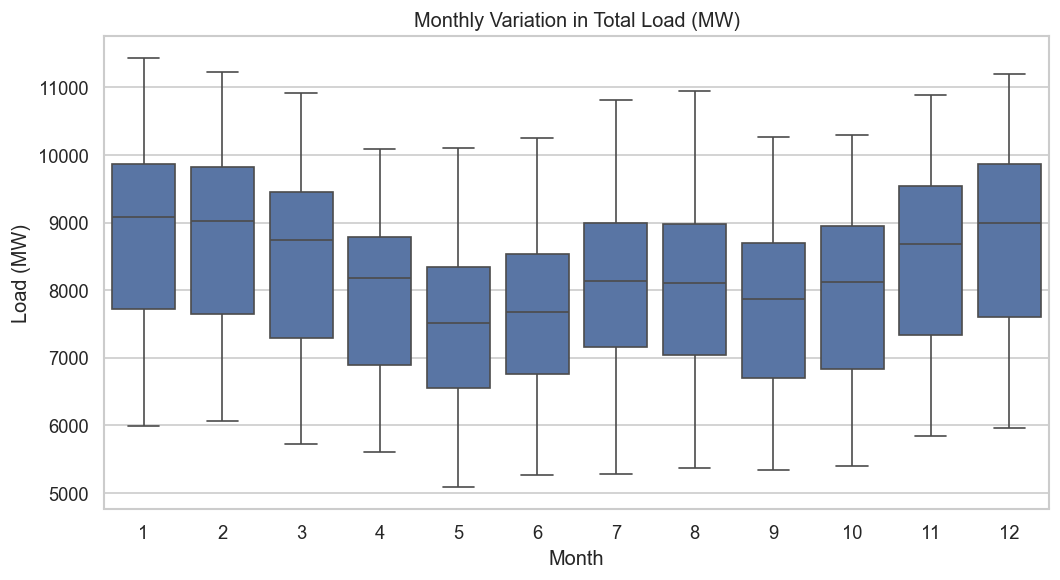

In [34]:
plt.figure(figsize=(9,5))
sns.boxplot(x="MONTH", y="TOTAL_LOAD", data=df_load)
plt.title("Monthly Variation in Total Load (MW)")
plt.xlabel("Month")
plt.ylabel("Load (MW)")
plt.tight_layout()
plt.show()


### Seasonal Heatmap

Heatmaps were created to visualize how demand changes by hour and day of the week within each season.
Winter shows the strongest weekday peaks, while weekends consistently have lower demand.

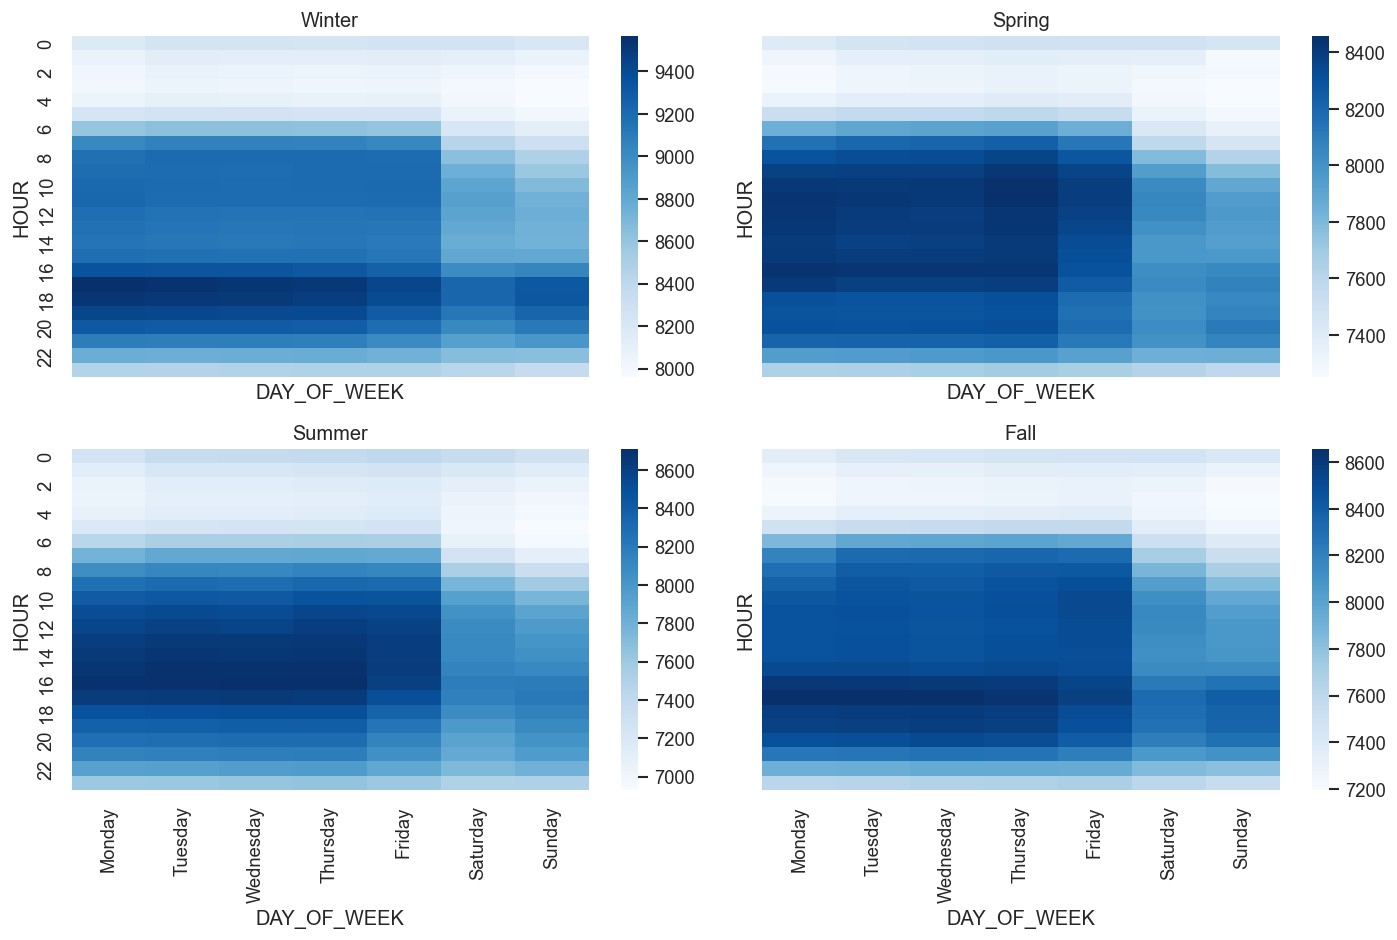

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)

for ax, s in zip(axes.ravel(), ["Winter","Spring","Summer","Fall"]):
    pv = (
        df_load[df_load["SEASON"] == s]
        .pivot_table(
            index="HOUR",
            columns="DAY_OF_WEEK",
            values="TOTAL_LOAD",
            aggfunc="mean"
        )
        [["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
    )
    sns.heatmap(pv, cmap="Blues", ax=ax)
    ax.set_title(s)

plt.tight_layout()
plt.show()


### Outlier Detection

The Interquartile Range (IQR) method was used to detect extreme values in `TOTAL_LOAD`.
indicating generally stable and realistic demand patterns.


Outliers found (TOTAL_LOAD): 0
IQR range used: 3943.2 to 12335.6


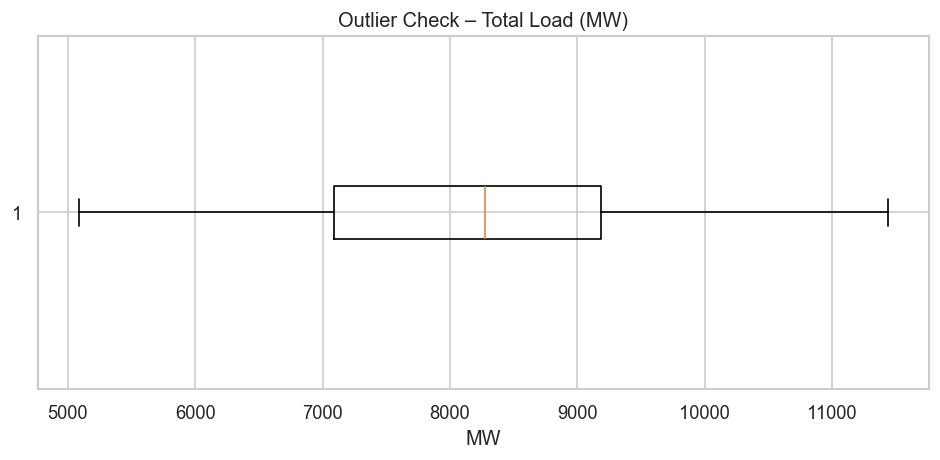

In [36]:
Q1 = df_load["TOTAL_LOAD"].quantile(0.25)
Q3 = df_load["TOTAL_LOAD"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df_load[(df_load["TOTAL_LOAD"] < lower) | (df_load["TOTAL_LOAD"] > upper)]
print("Outliers found (TOTAL_LOAD):", len(outliers))
print("IQR range used:", round(lower,1), "to", round(upper,1))

plt.figure(figsize=(8,4))
plt.boxplot(df_load["TOTAL_LOAD"], vert=False)
plt.title("Outlier Check – Total Load (MW)")
plt.xlabel("MW")
plt.tight_layout()
plt.show()


## Generation Data Processing

Hourly generation data was cleaned by:
- Standardizing column names
- Converting data types
- Handling missing and negative values
- Removing duplicates and invalid timestamps

This ensured consistency before analysis and merging.


In [ ]:
gen_path = Path("aeso_generation_hourly_long_2020_2025.csv")
df_gen = pd.read_csv(gen_path)

print("Raw generation columns:", df_gen.columns.tolist())


Raw generation columns: ['Date (MST)', 'Fuel Type', 'Volume']


In [ ]:
print("Missing:", df_gen["Volume"].isna().sum())
print("Negative values:", (df_gen["Volume"] < 0).sum())

Missing: 0
Negative values: 21251


### Clean column names and values

In [39]:
# Standardize names for this project
df_gen.rename(columns={
    "Date (MST)": "DT_MST",
    "Fuel Type":  "Fuel_Type"
}, inplace=True)

df_gen["DT_MST"]    = pd.to_datetime(df_gen["DT_MST"], errors="coerce")
df_gen["Fuel_Type"] = df_gen["Fuel_Type"].str.strip().str.title()
df_gen["Volume"]    = pd.to_numeric(df_gen["Volume"], errors="coerce").fillna(0)

# Simple negative handling:
# keep Energy Storage negatives if you want charging, or just clip
mask_storage = df_gen["Fuel_Type"].eq("Energy Storage")
df_gen.loc[~mask_storage, "Volume"] = df_gen.loc[~mask_storage, "Volume"].clip(lower=0)

df_gen = (
    df_gen
    .dropna(subset=["DT_MST"])
    .drop_duplicates()
    .sort_values("DT_MST")
    .reset_index(drop=True)
)

print("Generation data shape:", df_gen.shape)
print(df_gen.head(3))

Generation data shape: (368418, 3)
      DT_MST  Fuel_Type       Volume
0 2020-01-01       Coal  2643.222160
1 2020-01-01  Dual Fuel   186.735720
2 2020-01-01        Gas  5254.567138


### Hourly completeness check

In [40]:
tot = df_gen.groupby("DT_MST")["Volume"].sum()
rng = pd.date_range(tot.index.min(), tot.index.max(), freq="H")
missing_hours = rng.difference(tot.index)
print("Missing hourly stamps:", len(missing_hours))

Missing hourly stamps: 0


C:\Users\User\AppData\Local\Temp\ipykernel_6880\812989197.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rng = pd.date_range(tot.index.min(), tot.index.max(), freq="H")


In [ ]:
print("Missing:", df_gen["Volume"].isna().sum())
print("Negative values:", (df_gen["Volume"] < 0).sum())

Missing: 0
Negative values: 0


### EDA – Generation (2020–2025)

### Hourly total generation trend

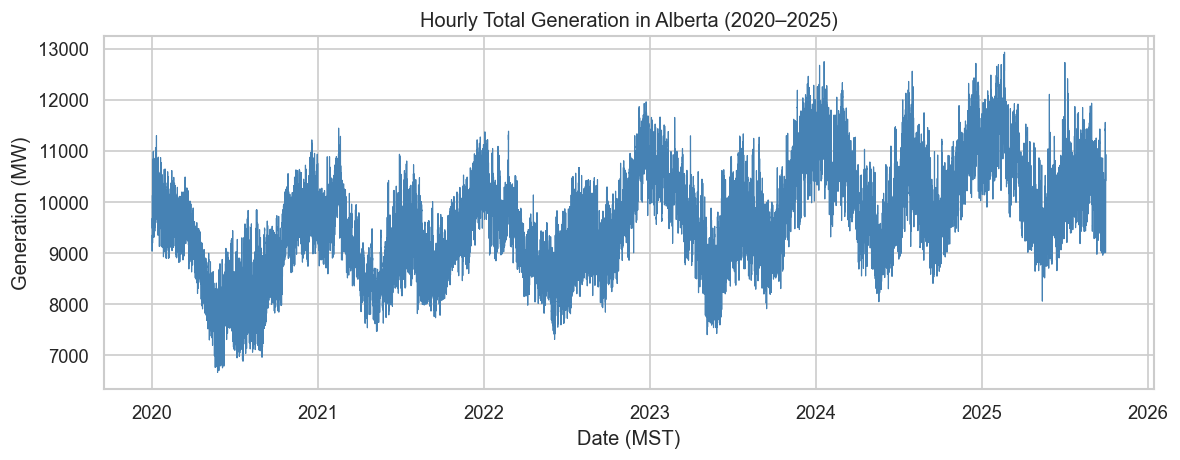

In [42]:
hourly_gen = df_gen.groupby("DT_MST")["Volume"].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(hourly_gen["DT_MST"], hourly_gen["Volume"], color="steelblue", linewidth=0.7)
plt.title("Hourly Total Generation in Alberta (2020–2025)")
plt.xlabel("Date (MST)")
plt.ylabel("Generation (MW)")
plt.tight_layout()
plt.show()


### Generation by Fuel Type

Average generation was calculated for each fuel type.
Natural gas is the dominant energy source, followed by coal and wind.
Other sources like solar and hydro contribute smaller portions.



Average generation by fuel (MW):
 Fuel_Type
Gas               6697.0
Coal              1357.6
Wind              1039.4
Dual Fuel          337.6
Other              256.4
Hydro              210.3
Solar              196.9
Energy Storage       0.2
Name: Volume, dtype: float64


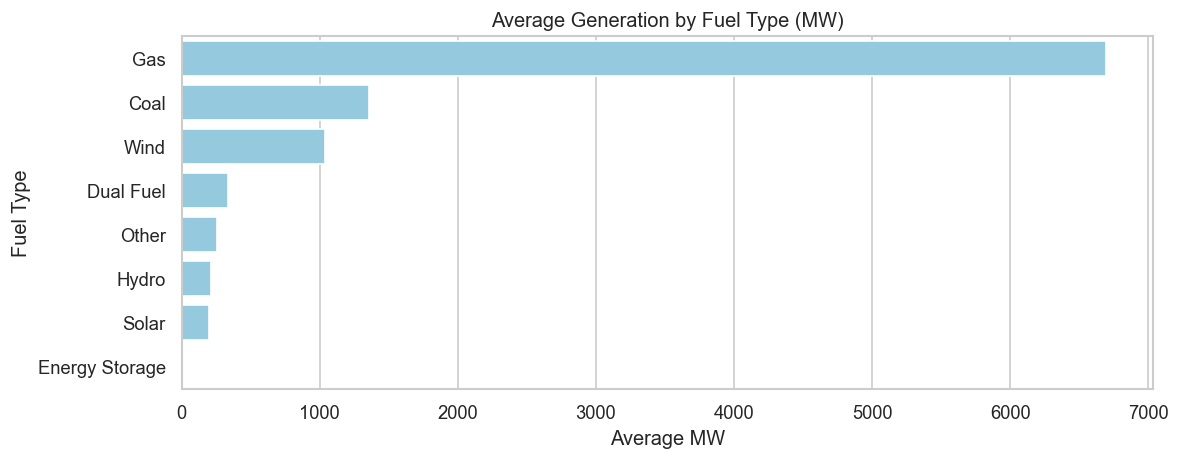

In [43]:
fuel_avg = df_gen.groupby("Fuel_Type")["Volume"].mean().sort_values(ascending=False)
print("\nAverage generation by fuel (MW):\n", fuel_avg.round(1))

plt.figure(figsize=(10,4))
sns.barplot(x=fuel_avg.values, y=fuel_avg.index, color="skyblue")
plt.title("Average Generation by Fuel Type (MW)")
plt.xlabel("Average MW")
plt.ylabel("Fuel Type")
plt.tight_layout()
plt.show()


### Outliers by fuel (boxplot)


Outliers by fuel type:
Coal: 5
Dual Fuel: 11
Energy Storage: 4258
Gas: 299
Hydro: 2017
Other: 467
Solar: 7743
Wind: 914


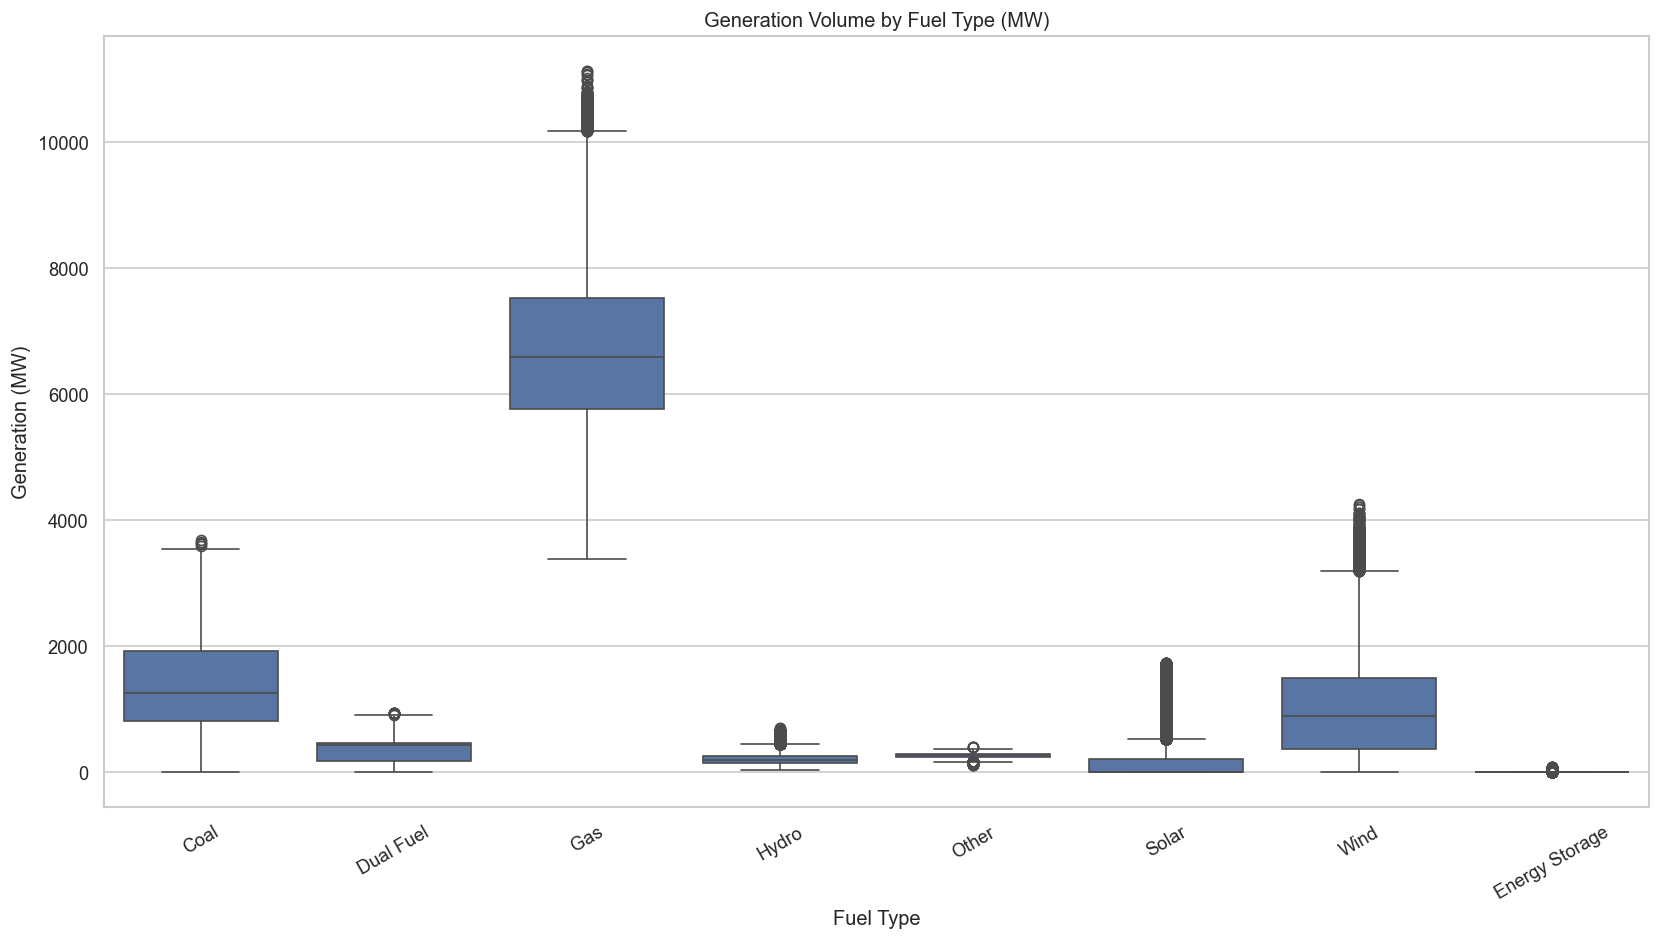

In [44]:
outlier_summary = {}

for fuel, grp in df_gen.groupby("Fuel_Type"):
    q1 = grp["Volume"].quantile(0.25)
    q3 = grp["Volume"].quantile(0.75)
    iqr = q3 - q1
    lower_f = q1 - 1.5 * iqr
    upper_f = q3 + 1.5 * iqr
    count = grp[(grp["Volume"] < lower_f) | (grp["Volume"] > upper_f)].shape[0]
    outlier_summary[fuel] = count

print("\nOutliers by fuel type:")
for k, v in outlier_summary.items():
    print(f"{k}: {v}")

plt.figure(figsize=(14,8))
sns.boxplot(data=df_gen, x="Fuel_Type", y="Volume")
plt.title("Generation Volume by Fuel Type (MW)")
plt.xlabel("Fuel Type")
plt.ylabel("Generation (MW)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Merge Load + Generation and create Surge file (Top 5% load)

In [45]:
# Restrict load to same date range as generation
start_gen = df_gen["DT_MST"].min().normalize()
end_gen   = df_gen["DT_MST"].max().normalize()

mask_overlap = (df_load["DT_MST"] >= start_gen) & (df_load["DT_MST"] <= end_gen)
df_load_overlap = df_load.loc[mask_overlap].copy()

print("Load overlap shape:", df_load_overlap.shape)
print("Overlap from", df_load_overlap["DT_MST"].min(), "to", df_load_overlap["DT_MST"].max())


Load overlap shape: (43847, 55)
Overlap from 2020-01-01 00:00:00 to 2024-12-31 23:00:00


### Pivot generation: Fuel_Type → columns

In [46]:
df_gen_wide = (
    df_gen
    .pivot(index="DT_MST", columns="Fuel_Type", values="Volume")
    .reset_index()
    .fillna(0)
)

df_gen_wide["Total_Generation_MW"] = df_gen_wide.drop(columns=["DT_MST"]).sum(axis=1)
print("Generation wide shape:", df_gen_wide.shape)
df_gen_wide.head()


Generation wide shape: (50399, 10)


Fuel_Type,DT_MST,Coal,Dual Fuel,Energy Storage,Gas,Hydro,Other,Solar,Wind,Total_Generation_MW
0,2020-01-01 00:00:00,2643.222160,186.735720,0.0,5254.567138,116.286112,264.669050,0.0,875.637983,9341.118162
1,2020-01-01 01:00:00,2627.509175,186.701740,0.0,5241.975509,107.122970,268.655356,0.0,778.695505,9210.660256
2,2020-01-01 02:00:00,2649.686923,186.608793,0.0,5226.280301,79.876501,268.498649,0.0,717.339528,9128.290695
3,2020-01-01 03:00:00,2600.240311,186.765521,0.0,5213.915698,88.670255,270.545203,0.0,691.670863,9051.807851
4,2020-01-01 04:00:00,2663.625278,185.704475,0.0,5249.345810,108.136037,271.065408,0.0,553.970998,9031.848006


### Merge on DT_MST

In [47]:
merged = pd.merge(df_load_overlap, df_gen_wide, on="DT_MST", how="inner")
print("Merged shape (load + generation):", merged.shape)


Merged shape (load + generation): (43847, 64)


### Surge Detection

Surge hours were defined as the top 5% of `TOTAL_LOAD` values.
The 95th percentile (~9,220 MW) was used as the threshold.
Each hour was labeled as either “Surge” or “Normal” for comparison.


In [48]:
p95 = merged["TOTAL_LOAD"].quantile(0.95)
merged["SURGE_FLAG"] = (merged["TOTAL_LOAD"] >= p95).astype(int)
merged["SURGE_LABEL"] = np.where(merged["SURGE_FLAG"] == 1, "Surge (Top 5%)", "Normal")

print(f"\nTop 5% surge threshold: {p95:,.0f} MW")
print("Surge hours:", merged["SURGE_FLAG"].sum(), "out of", len(merged))



Top 5% surge threshold: 9,220 MW
Surge hours: 2193 out of 43847


### Histogram of TOTAL_LOAD with surge threshold

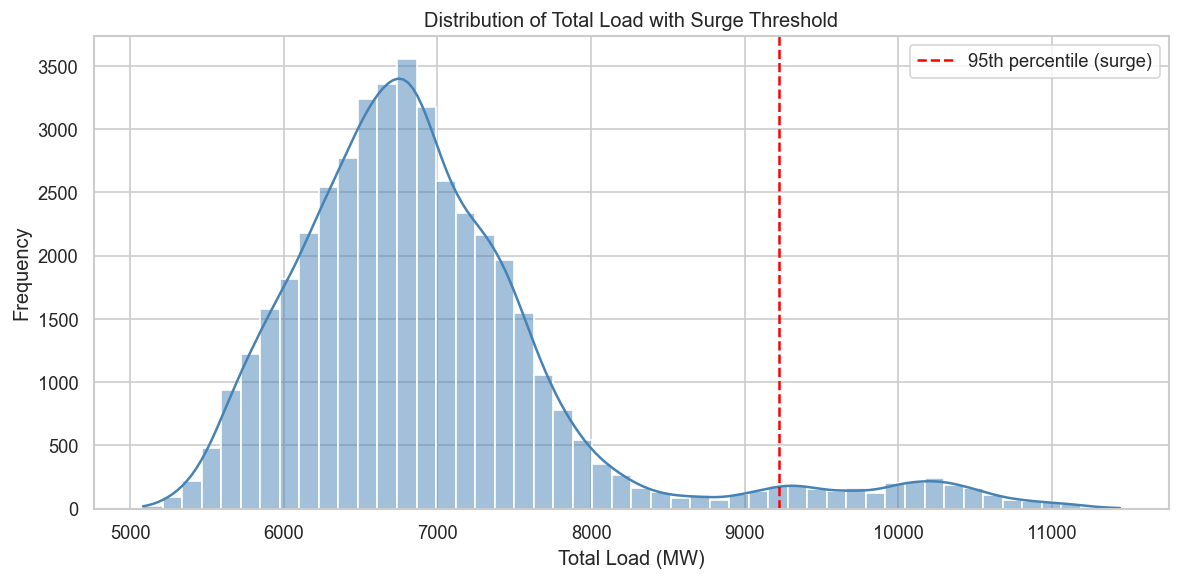

In [49]:
plt.figure(figsize=(10,5))
sns.histplot(data=merged, x="TOTAL_LOAD", bins=50, kde=True, color="steelblue")
plt.axvline(p95, color="red", linestyle="--", label="95th percentile (surge)")
plt.title("Distribution of Total Load with Surge Threshold")
plt.xlabel("Total Load (MW)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


### Population vs Generation

Population data was reshaped and combined with annual generation totals.
A strong positive correlation (~0.99) was found, indicating that increased population aligns with higher electricity generation needs.


In [ ]:
pop_path = "Alberta_Population_by_Custom_Region.csv"
pop = pd.read_csv(pop_path)

# Convert wide to long format
pop_long = pop.melt(id_vars="Region", var_name="Year", value_name="Population")
pop_long["Year"] = pop_long["Year"].astype(int)

# Total population by year
yearly_population = pop_long.groupby("Year")["Population"].sum().reset_index()
yearly_population.columns = ["Year", "Total_Population"]

print("\nYearly Population:")
print(yearly_population)

df_gen["YEAR"] = df_gen["DT_MST"].dt.year
yearly_generation = df_gen.groupby("YEAR")["Volume"].sum().reset_index()
yearly_generation.columns = ["Year", "Total_Generation_MWh"]

print("\nYearly Generation:")
print(yearly_generation)

# ---------- 3. Merge Generation + Population ----------
final = pd.merge(yearly_generation, yearly_population, on="Year", how="inner")

# ---------- 4. Correlation Matrix ----------
correlation = final[["Total_Generation_MWh", "Total_Population"]].corr()

print("\nGeneration vs Population Correlation Matrix:")
print(correlation)


Yearly Population:
   Year  Total_Population
0  2020           4407495
1  2021           4431531
2  2022           4510747
3  2023           4684514
4  2024           4888723

Yearly Generation:
   Year  Total_Generation_MWh
0  2020          7.908575e+07
1  2021          8.103909e+07
2  2022          8.281937e+07
3  2023          8.619434e+07
4  2024          9.066347e+07
5  2025          6.853855e+07

Generation vs Population Correlation Matrix:
                      Total_Generation_MWh  Total_Population
Total_Generation_MWh              1.000000          0.991851
Total_Population                  0.991851          1.000000


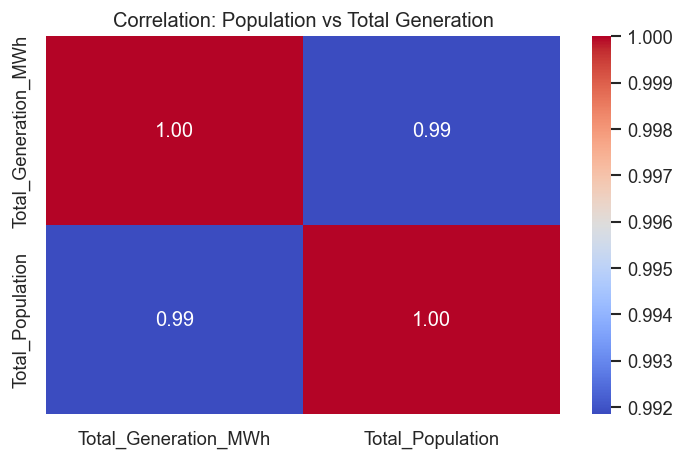

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation: Population vs Total Generation")
plt.tight_layout()
plt.show()


## Output for Tableau

Final cleaned datasets were exported for visualization in Tableau:
- Load data with engineered features
- Load + Generation + Surge data
- Yearly Population + Generation data

All transformations were completed in Python.


In [53]:

tableau_dir = Path(r"C:\DAB\sem2\env\capstone\Dataset\Tableau")
tableau_dir.mkdir(parents=True, exist_ok=True)

# 1) Final HOURLY LOAD file (2011–2024) with engineered features
load_out = tableau_dir / "AESO_Load_2011_2024_Final.csv"
df_load.to_csv(load_out, index=False)
print("✅ Saved final load file:", load_out)

# 2) Final GENERATION file (2020–2025) – clean LONG format by fuel
gen_long_out = tableau_dir / "AESO_Generation_By_Fuel_2020_2025_Clean.csv"
df_gen.to_csv(gen_long_out, index=False)
print("✅ Saved clean generation (long) file:", gen_long_out)

# 3) Final GENERATION file (2020–2025) – WIDE format (one column per fuel)
gen_wide_out = tableau_dir / "AESO_Generation_By_Fuel_2020_2025_Wide.csv"
df_gen_wide.to_csv(gen_wide_out, index=False)
print("✅ Saved generation (wide) file:", gen_wide_out)

# 4) Final MERGED LOAD + GENERATION + SURGE file (2020–2024)
merged_out = tableau_dir / "AESO_Load_Generation_2020_2024_with_Surge.csv"
merged.to_csv(merged_out, index=False)
print("✅ Saved merged load+generation+surge file:", merged_out)

# 5) Final YEARLY POPULATION + GENERATION file (2020–2024)
yearly_out = tableau_dir / "Generation_Population_Yearly_2020_2024.csv"
final.to_csv(yearly_out, index=False)
print("✅ Saved yearly population & generation file:", yearly_out)


✅ Saved final load file: C:\DAB\sem2\env\capstone\Dataset\Tableau\AESO_Load_2011_2024_Final.csv
✅ Saved clean generation (long) file: C:\DAB\sem2\env\capstone\Dataset\Tableau\AESO_Generation_By_Fuel_2020_2025_Clean.csv
✅ Saved generation (wide) file: C:\DAB\sem2\env\capstone\Dataset\Tableau\AESO_Generation_By_Fuel_2020_2025_Wide.csv
✅ Saved merged load+generation+surge file: C:\DAB\sem2\env\capstone\Dataset\Tableau\AESO_Load_Generation_2020_2024_with_Surge.csv
✅ Saved yearly population & generation file: C:\DAB\sem2\env\capstone\Dataset\Tableau\Generation_Population_Yearly_2020_2024.csv
